In [1]:
import bayes3d as b
import bayes3d.genjax
import joblib
from tqdm import tqdm
import os
import jax.numpy as jnp
import jax
import numpy as np
import genjax

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
intrinsics = b.Intrinsics(
    height=50,
    width=50,
    fx=250.0, fy=250.0,
    cx=25.0, cy=25.0,
    near=0.01, far=20.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 64, 1024)


In [4]:
importance_jit = jax.jit(b.model.importance)

contact_enumerators = [b.make_enumerator([f"contact_params_{i}", "variance", "outlier_prob"]) for i in range(5)]
add_object_jit = jax.jit(b.add_object)

def c2f_contact_update(trace_, key,  number, contact_param_deltas, VARIANCE_GRID, OUTLIER_GRID):
    contact_param_grid = contact_param_deltas + trace_[f"contact_params_{number}"]
    scores = contact_enumerators[number].score_vmap(trace_, key, contact_param_grid, VARIANCE_GRID, OUTLIER_GRID)
    i,j,k = jnp.unravel_index(scores.argmax(), scores.shape)
    return contact_enumerators[number].enum_f(
        trace_, key,
        contact_param_grid[i], VARIANCE_GRID[j], OUTLIER_GRID[k]
    )
c2f_contact_update_jit = jax.jit(c2f_contact_update, static_argnames=("number",))

In [5]:
OUTLIER_VOLUME = 1000.0
VARIANCE_GRID = jnp.array([0.0001, 0.001, 0.01])
OUTLIER_GRID = jnp.array([0.00001, 0.0001, 0.001])

grid_params = [
    (0.3, jnp.pi, (11,11,11)), (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi, (11,11,11)),
    (0.05, jnp.pi/3, (11,11,11)), (0.02, jnp.pi, (5,5,51)), (0.01, jnp.pi/5, (11,11,11)), (0.01, 0.0, (21,21,1)),(0.05, 0.0, (21,21,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]


In [6]:
V_VARIANT = 0
O_VARIANT = 0
HIERARCHICAL_BAYES = True

if HIERARCHICAL_BAYES:
    V_GRID = VARIANCE_GRID
    O_GRID = OUTLIER_GRID
else:
    V_GRID, O_GRID = jnp.array([VARIANCE_GRID[V_VARIANT]]), jnp.array([OUTLIER_GRID[O_VARIANT]])

print(V_GRID, O_GRID)

[1.e-04 1.e-03 1.e-02] [1.e-05 1.e-04 1.e-03]


In [7]:
key = jax.random.PRNGKey(502)

8002.788


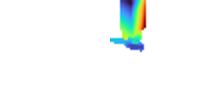

In [8]:
key = jax.random.split(key, 1)[0]
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 1.20]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

weight, gt_trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "parent_2": 0,
    "parent_3": 0,
    "id_0": jnp.int32(21),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 2,
    "face_parent_2": 2,
    "face_parent_3": 2,
    "face_child_1": 3,
    "face_child_2": 3,
    "face_child_3": 3,
    "variance": 0.0001,
    "outlier_prob": 0.0001,
}), (
    jnp.arange(4),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
    b.RENDERER.model_box_dims, OUTLIER_VOLUME, 1.0)
)
print(gt_trace.get_score())

_,trace = importance_jit(key, gt_trace.get_choices(), (jnp.arange(1), jnp.arange(22), *gt_trace.get_args()[2:]))
b.viz_trace_rendered_observed(trace)

In [9]:
all_all_paths = []
for _ in range(3):
    all_paths = []
    for obj_id in tqdm(range(len(b.RENDERER.meshes)-1)):
        path = []
        trace_ = add_object_jit(trace, key, obj_id, 0, 2,3)
        number = b.get_contact_params(trace_).shape[0] - 1
        path.append(trace_)
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            trace_ = c2f_contact_update_jit(trace_, key, number,
                contact_param_gridding_schedule[c2f_iter], V_GRID, O_GRID)
            path.append(trace_)
        # for c2f_iter in range(len(contact_param_gridding_schedule)):
        #     trace_ = c2f_contact_update_jit(trace_, key, number,
        #         contact_param_gridding_schedule[c2f_iter], VARIANCE_GRID, OUTLIER_GRID)
        all_paths.append(
            path
        )
    all_all_paths.append(all_paths)
    
    scores = jnp.array([t[-1].get_score() for t in all_paths])
    print(scores)
    normalized_scores = b.utils.normalize_log_scores(scores)
    trace = all_paths[jnp.argmax(scores)][-1]
    b.viz_trace_meshcat(trace)

100%|██████████| 21/21 [00:20<00:00,  1.04it/s]


[5773.0347 6945.969  6394.48   5012.1865 6203.7266 4498.753  4814.566
 4503.0493 4976.1084 4665.8467 6054.6133 6381.7896 4370.926  5175.4106
 5041.7944 6518.6846 4406.8076 4027.0176 4839.104  4861.1875 4601.657 ]


100%|██████████| 21/21 [00:17<00:00,  1.17it/s]


[6931.1304 7054.4    7433.7964 7435.2583 7473.678  7681.727  7692.0845
 7721.5767 7467.789  7702.636  6919.651  7380.9746 7274.0483 7643.685
 7744.58   6937.152  7740.2065 7727.8813 7909.5547 7851.405  7682.4165]


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


[7894.3765 7909.8687 7909.77   7901.3413 7903.3374 7907.858  7907.0166
 7907.846  7899.4375 7914.7827 7882.8975 7895.028  7734.6753 7904.4893
 7747.9175 7900.3975 7900.515  7901.3135 7908.7134 7816.007  7902.1675]


In [10]:
print(b.get_indices(gt_trace))
print(b.get_indices(trace))

[21  9 18  1]
[21  1 18  9]


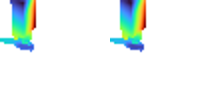

In [11]:
b.viz_trace_rendered_observed(trace)